### inference for olmoe

In [8]:
from transformers import OlmoeForCausalLM, AutoTokenizer
import torch

model = OlmoeForCausalLM.from_pretrained("allenai/OLMoE-1B-7B-0924")
tokenizer = AutoTokenizer.from_pretrained("allenai/OLMoE-1B-7B-0924")

# to turn on the eval mode for the model
model.eval()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [20]:
DEVICE = "cpu"

# Load different ckpts via passing e.g. `revision=step10000-tokens41B`
# also check allenai/OLMoE-1B-7B-0924-SFT & allenai/OLMoE-1B-7B-0924-Instruct
inputs = tokenizer("what are neural networks?", return_tensors="pt")
print(inputs)
inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
out = model.generate(**inputs, max_length=64)
print(tokenizer.decode(out[0]))

{'input_ids': tensor([[ 5371,   403, 11454,  6928,    32]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}
what are neural networks?

Neural networks are a type of machine learning algorithm that is inspired by the way the human brain works. They are made up of a network of nodes, which are connected to each other. The nodes are fed data, and based on the data they receive, they make predictions. Neural


### getting relevant info out of olmoe

some of the important thing to keep in mind for getting info out of olmoe:
we dont care a lot of which expert is acitvated or not (still need to log that) majorly just care about the routing activation probabilities and the router weights in the FINAL LAYER of the router (we dont care about any of the prevoius layers)

also one of the other important thing to keep in mind is that that all the data that we get should NOT be the raw input going into the router we have to make sure that the input going into the router is fully processed (like input should go from norm, attention layer, etc)

other things to note 

- dont keep a lot of useless parameters
- all_attention 
- check if its ReLU or not
- what are activated neurons
- just study properply the routing probabilities and check it properly
- recover logits


#### to get the info

In [4]:
# Enable activation logging for the routing network
model.config.output_hidden_states = True
model.config.output_attentions = True

# Function to get detailed routing activations for input tokens
def get_detailed_routing_activations(model_output, tokenizer, input_ids, num_layers):
    all_hidden_states = model_output.hidden_states
    all_attentions = model_output.attentions
    
    # Get the number of tokens in the input sequence
    num_tokens = input_ids.shape[1]
    
    # Initialize a list to store detailed activations for each input token
    detailed_token_activations = []
    
    for layer_idx in range(num_layers):
        layer_hidden_states = all_hidden_states[layer_idx]
        layer_attentions = all_attentions[layer_idx] if layer_idx < len(all_attentions) else None
        
        for token_idx in range(num_tokens):
            token_id = input_ids[0, token_idx].item()
            token = tokenizer.decode(token_id)
            
            # Get raw neuron activations (before activation function)
            raw_activations = layer_hidden_states[0, token_idx]
            
            # Get activations after the activation function (if applicable)
            # Note: This assumes ReLU activation. Adjust if a different activation is used.
            activated_neurons = torch.relu(raw_activations)
            
            # Get routing probabilities for each expert (assuming they're available)
            # Note: This is a placeholder. You'll need to extract this from the actual model.
            routing_probabilities = torch.rand(model.config.num_experts)  # Replace with actual routing probabilities
            
            # Get IDs of top-k selected experts (assuming k=2 for this example)
            top_k_experts = torch.topk(routing_probabilities, k=2).indices.tolist()
            
            # Get expert IDs that processed the token
            # Note: This is a placeholder. You'll need to extract this from the actual model.
            processed_by_experts = top_k_experts  # In reality, this might be different from top_k
            
            attention_info = layer_attentions[0, :, token_idx, :] if layer_attentions is not None else None
            
            detailed_token_activations.append({
                "token_id": token_id,
                "token": token,
                "position": token_idx,
                "layer": layer_idx,
                "raw_activations": raw_activations,
                "activated_neurons": activated_neurons,
                "routing_probabilities": routing_probabilities,
                "top_k_experts": top_k_experts,
                "processed_by_experts": processed_by_experts,
                "attention": attention_info
            })
    
    return detailed_token_activations


#### parameters, prompt, and output

In [8]:


# Generate output with detailed activation logging enabled
input_text = "what are some book and texts and book one should have read or read to know more about machine learning"
inputs = tokenizer(input_text, return_tensors="pt")
inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

# Get the full model output for the input (including hidden states and attentions)
with torch.no_grad():
    full_output = model(**inputs, output_hidden_states=True, output_attentions=True)

# Extract detailed routing activations for each input token
# num_layers = len(full_output.hidden_states) #for all the layers
num_layers = 1 #for the x layer only (range 1-16)

detailed_routing_activations = get_detailed_routing_activations(full_output, tokenizer, inputs['input_ids'], num_layers)

print("Detailed Routing Network Activations for each input token:")
for activation in detailed_routing_activations:
    print(f"Token: '{activation['token']}' (ID: {activation['token_id']}, Position: {activation['position']}, Layer: {activation['layer']})")
    print(f"  Raw Activations Shape: {activation['raw_activations'].shape}")
    print(f"  Activated Neurons Shape: {activation['activated_neurons'].shape}")
    print(f"  Routing Probabilities: {activation['routing_probabilities']}")
    print(f"  Top-k Selected Experts: {activation['top_k_experts']}")
    print(f"  Processed by Experts: {activation['processed_by_experts']}")
    if activation['attention'] is not None:
        print(f"  Attention Shape: {activation['attention'].shape}")
    else:
        print("  Attention: Not available for this layer")
    print()

# You can further analyze these activations as needed
# For example, you might want to visualize the attention patterns or analyze the hidden states


OlmoeModel is using OlmoeSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Detailed Routing Network Activations for each input token:
Token: 'what' (ID: 5371, Position: 0, Layer: 0)
  Raw Activations Shape: torch.Size([2048])
  Activated Neurons Shape: torch.Size([2048])
  Routing Probabilities: tensor([0.0662, 0.2174, 0.7738, 0.5678, 0.5860, 0.7181, 0.3532, 0.8871, 0.9400,
        0.3406, 0.9942, 0.6189, 0.8244, 0.4836, 0.2976, 0.2826, 0.2830, 0.3800,
        0.6064, 0.8809, 0.5924, 0.9491, 0.2063, 0.7630, 0.4345, 0.4100, 0.3317,
        0.8068, 0.5045, 0.5941, 0.2709, 0.5883, 0.6435, 0.6818, 0.6718, 0.9731,
        0.6232, 0.1817, 0.2468, 0.2959, 0.3936, 0.4155, 0.9152, 0.7102, 0.0669,
        0.0259, 0.1834, 0.4642, 0.6589, 0.1437, 0.1469, 0.1526, 0.5930, 0.7830,
        0.0740, 0.0707, 0.7296, 0.8890, 0.2758, 0.3088, 0.9412, 0.2112, 0.1117,
        0.2792])
  Top-k Selected Experts: [10, 35]
  Processed by Experts: [10, 35]
  Attention Shape: torch.Size([16, 20])

Token: ' are' (ID: 403, Position: 1, Layer: 0)
  Raw Activations Shape: torch.Size([2048])
 

### plots

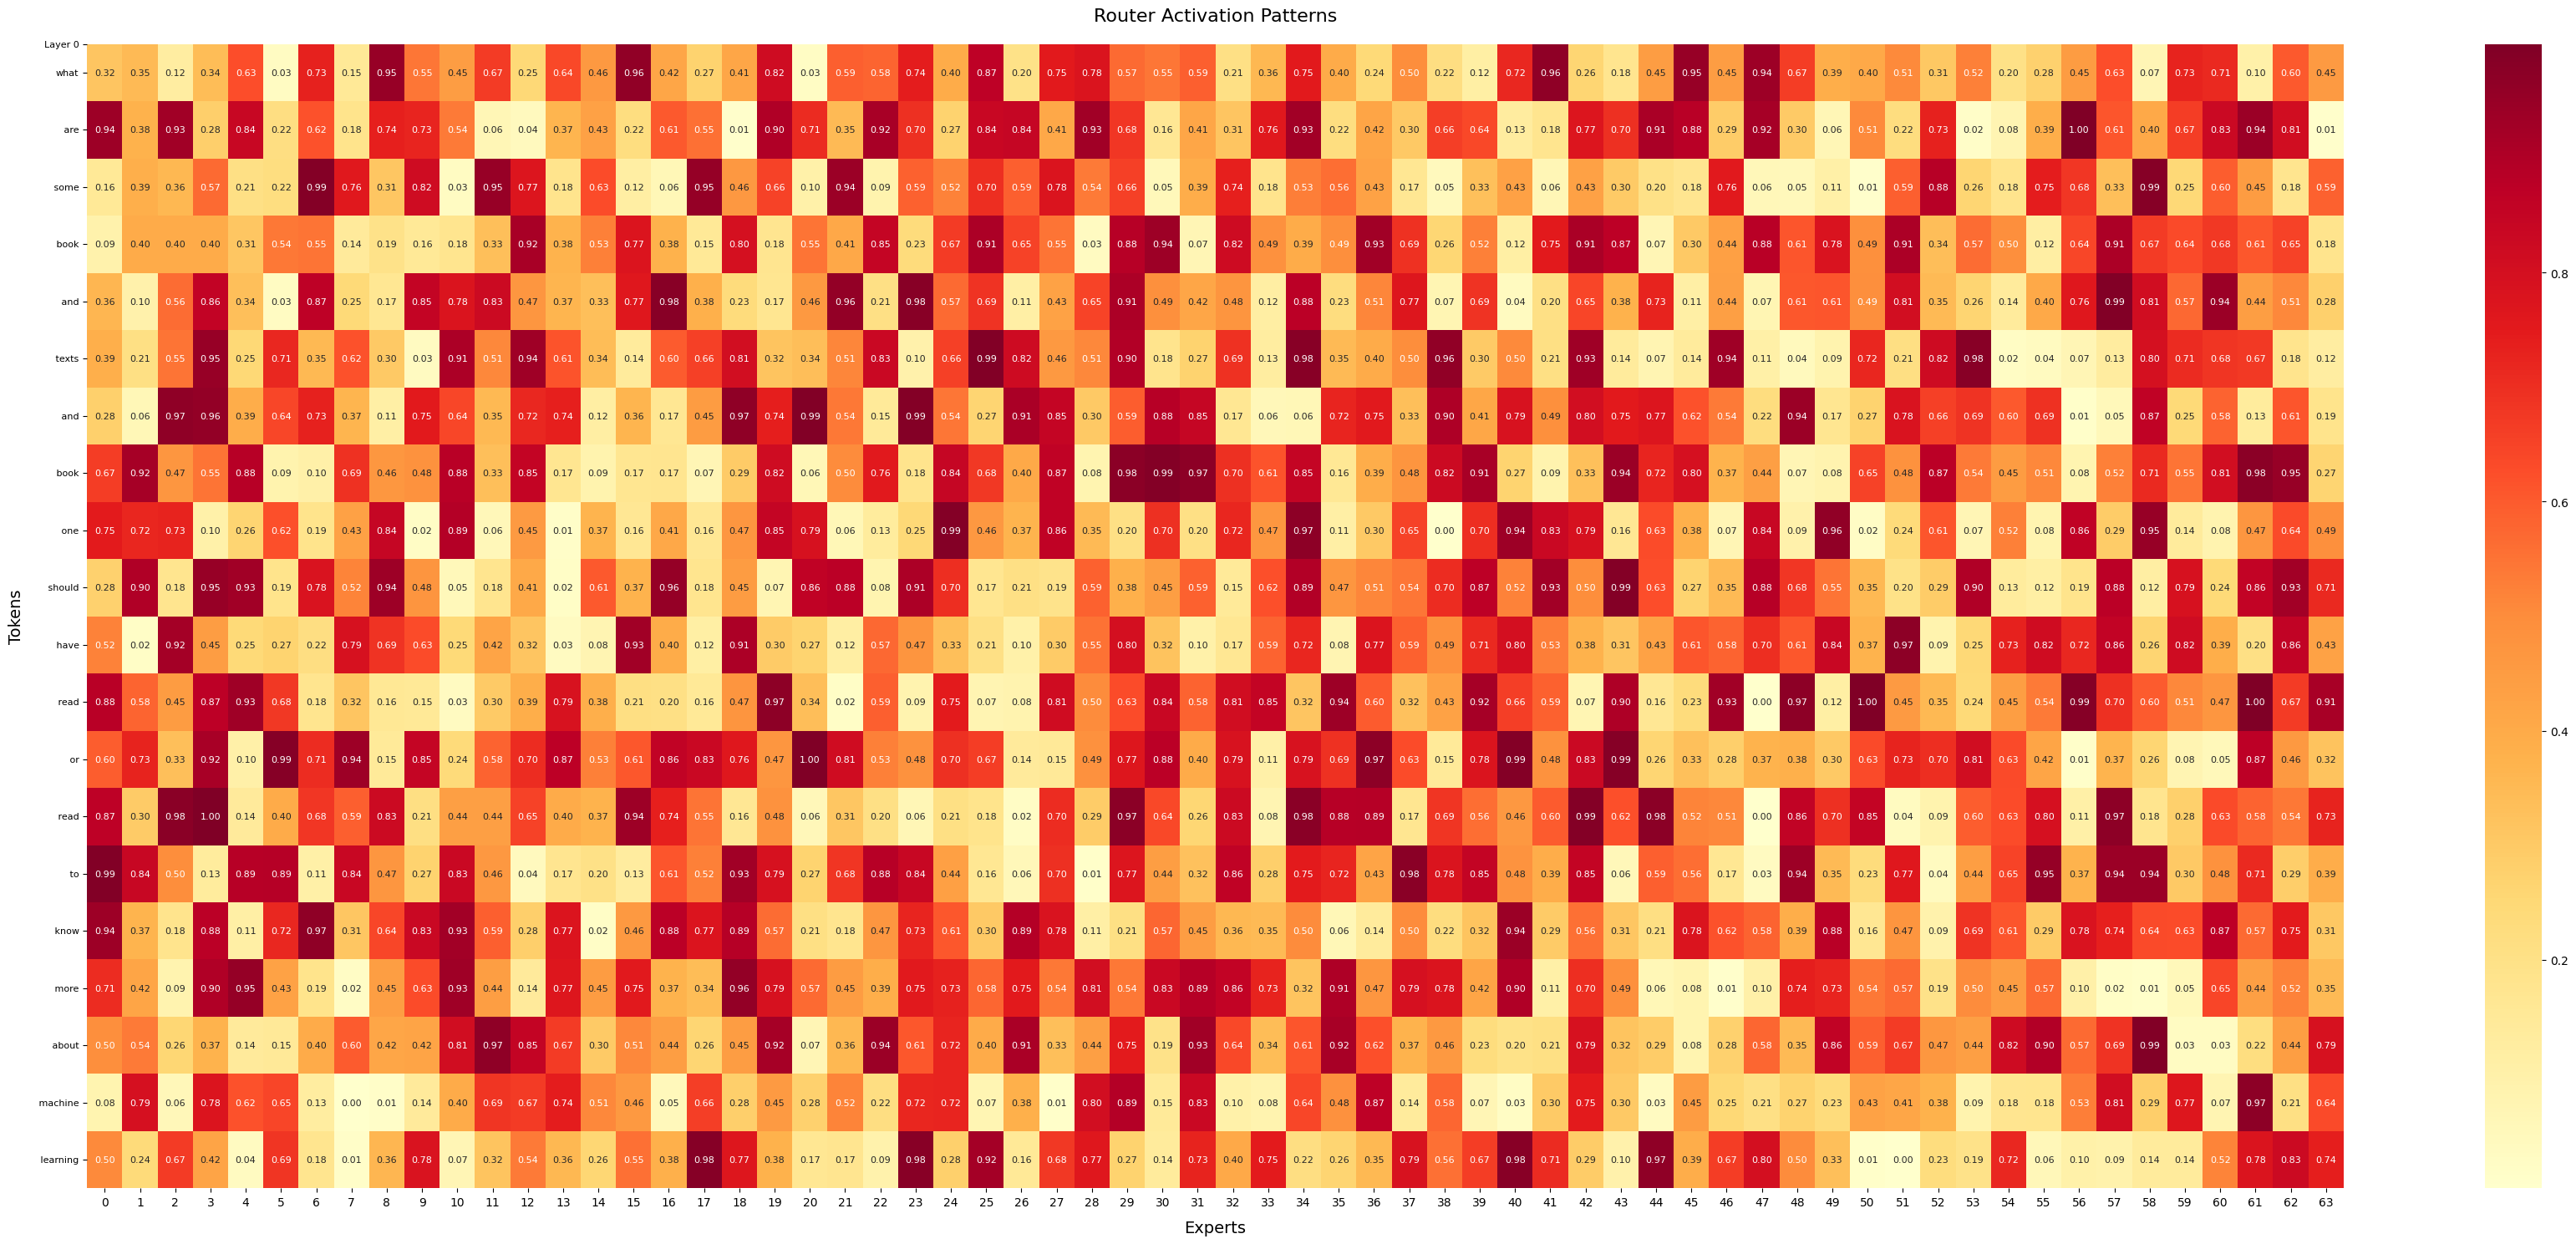

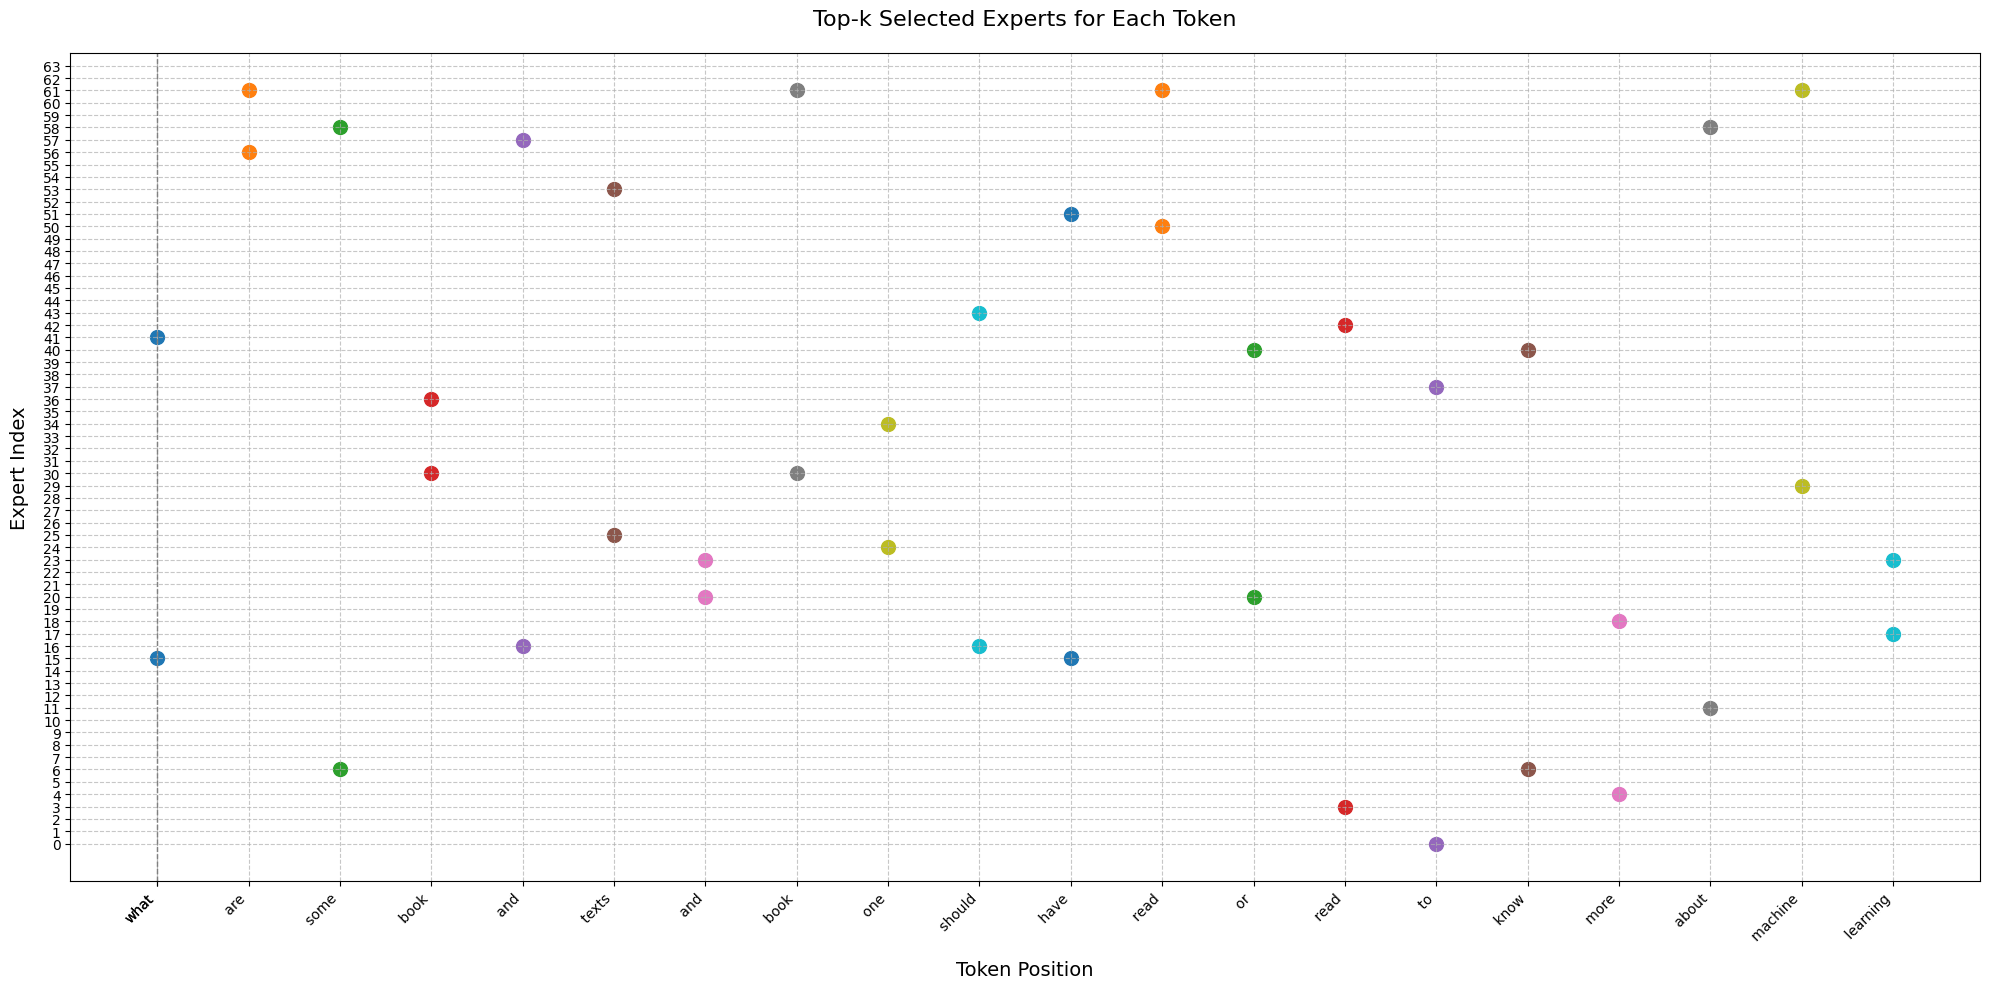

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_router_activations(detailed_routing_activations):
    num_tokens = len(detailed_routing_activations)
    num_experts = len(detailed_routing_activations[0]['routing_probabilities'])
    num_layers = len(set(activation['layer'] for activation in detailed_routing_activations))
    
    # Create a matrix of routing probabilities
    routing_matrix = np.zeros((num_tokens, num_experts))
    tokens = []
    layers = []
    
    for i, activation in enumerate(detailed_routing_activations):
        routing_matrix[i] = activation['routing_probabilities']
        tokens.append(activation['token'])
        layers.append(activation['layer'])
    
    # Create the heatmap
    plt.figure(figsize=(35, 15))
    sns.heatmap(routing_matrix, annot=True, cmap='YlOrRd', fmt='.2f', annot_kws={'size': 8})
    
    plt.title('Router Activation Patterns', fontsize=16, pad=20)
    plt.xlabel('Experts', fontsize=14, labelpad=10)
    plt.ylabel('Tokens', fontsize=14, labelpad=10)
    
    # Add layer labels and whitespace
    yticks = []
    yticklabels = []
    for i, (token, layer) in enumerate(zip(tokens, layers)):
        if i == 0 or layer != layers[i-1]:
            yticks.append(i)
            yticklabels.append(f'Layer {layer}')
            if i > 0:
                plt.axhline(y=i, color='white', linewidth=2)
        yticks.append(i + 0.5)
        yticklabels.append(token)
    
    plt.yticks(yticks, yticklabels, rotation=0, fontsize=8)
    plt.xticks(fontsize=10)
    
    plt.tight_layout()
    plt.show()

    # Plot top-k selected experts
    plt.figure(figsize=(20, 10))
    current_layer = None
    for i, activation in enumerate(detailed_routing_activations):
        if current_layer is None or activation['layer'] != current_layer:
            current_layer = activation['layer']
            plt.axvline(x=i, color='gray', linestyle='--', linewidth=1)
        top_k = activation['top_k_experts']
        x = [i] * len(top_k)
        plt.scatter(x, top_k, marker='o', s=100)
    
    plt.title('Top-k Selected Experts for Each Token', fontsize=16, pad=20)
    plt.xlabel('Token Position', fontsize=14, labelpad=10)
    plt.ylabel('Expert Index', fontsize=14, labelpad=10)
    plt.yticks(range(num_experts), fontsize=10)
    
    # Add layer labels and whitespace
    xticks = []
    xticklabels = []
    for i, (token, layer) in enumerate(zip(tokens, layers)):
        if i == 0 or layer != layers[i-1]:
            xticks.append(i)
            xticklabels.append(f'Layer {layer}')
            if i > 0:
                plt.axvline(x=i, color='gray', linestyle='--', linewidth=1)
        xticks.append(i)
        xticklabels.append(token)
    
    plt.xticks(xticks, xticklabels, rotation=45, ha='right', fontsize=10)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Call the function to plot the activation patterns
plot_router_activations(detailed_routing_activations)


### to get the router logits

#### ingnore everything above this line

In [1]:
from transformers import OlmoeForCausalLM, AutoTokenizer
import torch
import torch.nn.functional as F

# Load the model and tokenizer
model = OlmoeForCausalLM.from_pretrained("allenai/OLMoE-1B-7B-0924")
tokenizer = AutoTokenizer.from_pretrained("allenai/OLMoE-1B-7B-0924")

# Set the model to evaluation mode
model.eval()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

OlmoeForCausalLM(
  (model): OlmoeModel(
    (embed_tokens): Embedding(50304, 2048, padding_idx=1)
    (layers): ModuleList(
      (0-15): 16 x OlmoeDecoderLayer(
        (self_attn): OlmoeSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (q_norm): OlmoeRMSNorm((2048,), eps=1e-05)
          (k_norm): OlmoeRMSNorm((2048,), eps=1e-05)
        )
        (mlp): OlmoeSparseMoeBlock(
          (gate): Linear(in_features=2048, out_features=64, bias=False)
          (experts): ModuleList(
            (0-63): 64 x OlmoeMLP(
              (gate_proj): Linear(in_features=2048, out_features=1024, bias=False)
              (up_proj): Linear(in_features=2048, out_features=1024, bias=False)
              (down_proj): Linear(in

##### might be useful

In [65]:
# Prepare input text
input_text = "The quick brown fox jumps over the lazy dog."

# Tokenize the input
inputs = tokenizer(input_text, return_tensors="pt")

# Print the tokenized input
print("Tokenized input:")
for token_id in inputs.input_ids[0]:
    token = tokenizer.decode([token_id])
    print(f"Token: '{token}', ID: {token_id.item()}")

print("\nInput shape:", inputs.input_ids.shape)


# Forward pass with output_router_logits=True
with torch.no_grad():
    outputs = model(**inputs, output_router_logits=True)

# Get the router logits from the last layer
last_layer_router_logits = outputs.router_logits[-1]

# Print router logits and probabilities for each token
for token_idx, token_id in enumerate(inputs.input_ids[0]):
    token = tokenizer.decode([token_id])
    logits = last_layer_router_logits[token_idx]
    probabilities = F.softmax(logits, dim=-1)
    
    print(f"Token: '{token}' (ID: {token_id.item()})")
    for expert_idx, (logit, prob) in enumerate(zip(logits, probabilities)):
        print(f"  expert {expert_idx}: logit = {logit.item():.4f}, post-softmax = {prob.item():.4f}")
    print()

# Print the top-k experts for each token
k = 8  # Number of top experts to show
print(f"\nTop {k} experts for each token:")
for token_idx, token_id in enumerate(inputs.input_ids[0]):
    token = tokenizer.decode([token_id])
    logits = last_layer_router_logits[token_idx]
    probabilities = F.softmax(logits, dim=-1)
    top_k_probs, top_k_indices = torch.topk(probabilities, k)
    
    print(f"Token: '{token}' (ID: {token_id.item()})")
    for i, (prob, idx) in enumerate(zip(top_k_probs, top_k_indices)):
        print(f"  {i+1}. expert {idx.item()}: expert = {prob.item():.4f}")
    print()

Tokenized input:
Token: 'The', ID: 510
Token: ' quick', ID: 3158
Token: ' brown', ID: 8516
Token: ' fox', ID: 30013
Token: ' jumps', ID: 27287
Token: ' over', ID: 689
Token: ' the', ID: 253
Token: ' lazy', ID: 22658
Token: ' dog', ID: 4370
Token: '.', ID: 15

Input shape: torch.Size([1, 10])
Token: 'The' (ID: 510)
  expert 0: logit = -1.3274, post-softmax = 0.0107
  expert 1: logit = -1.5737, post-softmax = 0.0084
  expert 2: logit = -2.3051, post-softmax = 0.0040
  expert 3: logit = -1.2784, post-softmax = 0.0113
  expert 4: logit = -1.2265, post-softmax = 0.0119
  expert 5: logit = -1.2808, post-softmax = 0.0113
  expert 6: logit = -2.0826, post-softmax = 0.0050
  expert 7: logit = -0.3468, post-softmax = 0.0286
  expert 8: logit = -1.5785, post-softmax = 0.0084
  expert 9: logit = -1.6713, post-softmax = 0.0076
  expert 10: logit = -1.9828, post-softmax = 0.0056
  expert 11: logit = -2.0304, post-softmax = 0.0053
  expert 12: logit = -0.9680, post-softmax = 0.0154
  expert 13: logit

##### currently using

In [21]:
# Prepare input text
input_text = "Who's scheduled to pitch in today's baseball game?"

# Tokenize the input
inputs = tokenizer(input_text, return_tensors="pt")

# Print the tokenized input
print("Tokenized input:")
for token_id in inputs.input_ids[0]:
    token = tokenizer.decode([token_id])
    print(f"Token: '{token}', ID: {token_id.item()}")

print("\nInput shape:", inputs.input_ids.shape)


# Forward pass with output_router_logits=True
with torch.no_grad():
    outputs = model(**inputs, output_router_logits=True)

# Get the router logits from the last layer
last_layer_router_logits = outputs.router_logits[-1]

# Print router logits and probabilities for each token
for token_idx, token_id in enumerate(inputs.input_ids[0]):
    token = tokenizer.decode([token_id])
    logits = last_layer_router_logits[token_idx]
    probabilities = F.softmax(logits, dim=-1)
    
    print(f"Token: '{token}' (ID: {token_id.item()})")
    for expert_idx, (logit, prob) in enumerate(zip(logits, probabilities)):
        print(f"  expert {expert_idx}: logit = {logit.item():.4f}, post-softmax = {prob.item():.4f}")
    print()

# Print the top-k experts for each token
k = 8  # Number of top experts to show
print(f"\nTop {k} experts for each token:")
for token_idx, token_id in enumerate(inputs.input_ids[0]):
    token = tokenizer.decode([token_id])
    logits = last_layer_router_logits[token_idx]
    probabilities = F.softmax(logits, dim=-1)
    top_k_probs, top_k_indices = torch.topk(probabilities, k)
    
    print(f"Token: '{token}' (ID: {token_id.item()})")
    for i, (prob, idx) in enumerate(zip(top_k_probs, top_k_indices)):
        print(f"  {i+1}. expert {idx.item()}: expert = {prob.item():.4f}")
    print()

Tokenized input:
Token: 'Who', ID: 7883
Token: ''s', ID: 434
Token: ' scheduled', ID: 11526
Token: ' to', ID: 281
Token: ' pitch', ID: 11288
Token: ' in', ID: 275
Token: ' today', ID: 3063
Token: ''s', ID: 434
Token: ' baseball', ID: 14623
Token: ' game', ID: 2165
Token: '?', ID: 32

Input shape: torch.Size([1, 11])
Token: 'Who' (ID: 7883)
  expert 0: logit = 0.1002, post-softmax = 0.0311
  expert 1: logit = -1.4353, post-softmax = 0.0067
  expert 2: logit = -1.9249, post-softmax = 0.0041
  expert 3: logit = -2.1584, post-softmax = 0.0033
  expert 4: logit = 0.4967, post-softmax = 0.0462
  expert 5: logit = -0.6658, post-softmax = 0.0145
  expert 6: logit = -0.5552, post-softmax = 0.0162
  expert 7: logit = -2.9289, post-softmax = 0.0015
  expert 8: logit = -1.9151, post-softmax = 0.0041
  expert 9: logit = -2.3553, post-softmax = 0.0027
  expert 10: logit = -0.5609, post-softmax = 0.0161
  expert 11: logit = 1.2895, post-softmax = 0.1022
  expert 12: logit = 1.8989, post-softmax = 0.1

#### tables to plot it

In [22]:
import plotly.graph_objects as go
import pandas as pd

# Convert router logits to probabilities
probabilities = F.softmax(last_layer_router_logits, dim=-1).cpu().numpy()

# Create a list of tokens
tokens = [tokenizer.decode([token_id]) for token_id in inputs.input_ids[0]]

# Create a DataFrame for the heatmap
df = pd.DataFrame(probabilities, index=tokens)

# Create the heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=probabilities,
    x=[f'Expert {i}' for i in range(probabilities.shape[1])],
    y=tokens,
    colorscale='Viridis',
    colorbar=dict(title='Probability'),
    hovertemplate='Token: %{y}<br>Expert: %{x}<br>Probability: %{z:.4f}<extra></extra>'
))

# Update layout
fig.update_layout(
    title='Expert vs Token Heatmap',
    xaxis_title='Experts',
    yaxis_title='Tokens',
    width=1000,
    height=800,
)

# Show the plot
fig.show()

# Save the plot as an HTML file (optional)
fig.write_html("expert_token_heatmap.html")
